In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [3]:
if device.type == 'cuda':
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [4]:
torch.version.cuda

In [5]:
torch.cuda.empty_cache()

# Reading the data:

In [6]:
X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')

In [7]:
X.head()

,ram,#ofcores,utilization_mean,temp_mean,IT_dur_ms,Anti-Virus_dur_ms,Communication_dur_ms,Game_dur_ms,Installer/Updater_dur_ms,Internet_dur_ms,...,cpu_family_Core i5,cpu_family_Core i7,cpu_family_Core i9,cpu_family_Core2,cpu_family_Pentium/Celeron,cpu_family_Xeon,discretegraphics_N,discretegraphics_Y,vpro_enabled_N,vpro_enabled_Y
0,8.0,2.0,41.812885,39.290535,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
1,8.0,2.0,23.001764,41.529495,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
2,6.0,2.0,42.331238,54.387505,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,1,0
3,12.0,4.0,45.096786,58.178394,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
4,8.0,2.0,45.435486,33.730610,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


In [8]:
Y

,persona
0,1
1,0
2,0
3,1
4,2
...,...
12972,1
12973,0
12974,0
12975,1


In [9]:
Y.drop_duplicates() # there are 4 classes

,persona
0,1
1,0
4,2
156,3


# <ins>I. Classification using MLP:<ins>

## 1) Pre-processing:

In [11]:
# concatenate X & Y to make random splitting
df = X
df['Y'] = Y
df.head()

,ram,#ofcores,utilization_mean,temp_mean,IT_dur_ms,Anti-Virus_dur_ms,Communication_dur_ms,Game_dur_ms,Installer/Updater_dur_ms,Internet_dur_ms,...,cpu_family_Core i7,cpu_family_Core i9,cpu_family_Core2,cpu_family_Pentium/Celeron,cpu_family_Xeon,discretegraphics_N,discretegraphics_Y,vpro_enabled_N,vpro_enabled_Y,Y
0,8.0,2.0,41.812885,39.290535,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,1
1,8.0,2.0,23.001764,41.529495,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
2,6.0,2.0,42.331238,54.387505,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
3,12.0,4.0,45.096786,58.178394,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,1
4,8.0,2.0,45.435486,33.730610,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,2


In [12]:
# Train-Test-Split
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=True, random_state=0)

In [13]:
# X -- event features
X_train = torch.tensor(df_train.values).to(device)
X_test = torch.tensor(df_test.values).to(device)

# Y -- label
Y_train = torch.tensor(df_train[['Y']].values).to(device)
Y_test = torch.tensor(df_test[['Y']].values).to(device)

In [14]:
num_features = X_train.shape[1]
print("Number of trainable features is:", num_features)

Number of trainable features is: 462


### Dataloader:

In [107]:
import torchvision
from torch.utils.data import Dataset, DataLoader

class Dataset_train(Dataset):

    def __init__(self):
        self.x = X_train
        self.y = Y_train
        
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

class Dataset_test(Dataset):

    def __init__(self):
        self.x = X_test
        self.y = Y_test
        
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples
    
dataset_train = Dataset_train()
dataset_test = Dataset_test()

In [108]:
# this helps create a data loader which iterates over tuples of target/labels with specfied batch size
# everytime the next function is called we receive the next batch sample & target until we cover all the data

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True)

In [109]:
# that's how you claim a batch to feed to the model
next(iter(train_loader))

[tensor([[ 8.0000,  2.0000, 47.2251, 45.2511,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.000

In [110]:
next(iter(test_loader))

[tensor([[ 8.0000,  2.0000, 38.2091, 53.1600,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.000

## 2) Model of the MLP classifier:

In [124]:
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

class Classifier(nn.Module):
    
    def __init__(self, width, n_inputs):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(in_features=width, out_features=width)
        self.h2 = nn.Linear(in_features=width, out_features=width)
    
        # output layer
        self.output = nn.Linear(width, 4)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = F.softmax(self.output(x), dim=1)
    
        return x

## 3) Training of the MLP classifier:

In [125]:
# this is a quick check that the model accepts the input and spits an output of a correct class

# create the network
network = Classifier(800, n_inputs=num_features).to(device)

# choose the criterion for the loss function (for multiclassification we usually use Cross Entropy)
criterion = nn.CrossEntropyLoss()

# create the optimiser (based on Gradient Descent)
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

# keep track of the losses
losses = []
losses_test = []

avg_losses = []               ######## for plotting we need losses per epoch
avg_losses_test = []

for batch in tqdm(train_loader):

    X,Y = batch

    # forwardprop
    preds = network(X.float())
    loss = criterion(preds,Y.reshape(-1))

    break
    
print(preds)
print(Y)
print(loss)

<ipython-input-125-9328d2172f67>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_loader):



tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.2357, 0.2667, 0.2461, 0.2515]], grad_fn=<SoftmaxBackward>)
tensor([[2],
        [2]])
tensor(1.5670, grad_fn=<NllLossBackward>)


In [140]:
from tqdm import tqdm_notebook as tqdm
import time

def normal_training(epochs=20, batch_size = 32, learning_rate=0.01):        

    # create the network
    network = Classifier(1000, n_inputs=num_features).to(device)

    # choose the criterion
    criterion = nn.CrossEntropyLoss()

    # create the optimiser
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    # keep track of the losses
    losses_train = []
    losses_test = []

    avg_losses_train = []               ######## for plotting we need losses per epoch
    avg_losses_test = []

    # create data loaders to begin the training
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size)

    # start a timer
    begt = time.time()
    
    for epoch in tqdm(range(epochs)):
        
        # to evaluate accuracies while training
        correct_preds_train = 0
        correct_preds_test = 0
        
        for batch in tqdm(train_loader):
            
            X,Y = batch

            # forwardprop
            preds = network(X.float())
            loss_train = criterion(preds,Y.reshape(-1))

            # backprop
            optimizer.zero_grad()                    ######## To avoid accumulating the gradients
            loss_train.backward()
            optimizer.step()

            losses_train.append(loss_train.to('cpu').detach().numpy())

            # feedback to assess training accuracy
            correct_preds_train += (preds.argmax(axis=1)==Y.reshape(-1)).sum().item()
                        
        train_acc = correct_preds_train/(len(train_loader)*batch_size)

        # check model performance on test data
        with torch.no_grad():                  ### important to specefy that you don't need pytorch to calculate gradients
            for batch in test_loader:

                X,Y = batch

                # forwardprop
                preds = network(X.float())
                loss_test = criterion(preds,Y.reshape(-1)) 
                losses_test.append(loss_test.to('cpu').detach().numpy())
            
                # feedback to assess testing accuracy
                correct_preds_test += (preds.argmax(axis=1)==Y.reshape(-1)).sum().item()

        test_acc = correct_preds_test/(len(test_loader)*batch_size)

        # calculate loss averages to use them in plots
        avg_losses_train.append(np.mean(losses_train)) 
        avg_losses_test.append(np.mean(losses_test))

        print("Epoch:", epoch+1, " - train_loss:", avg_losses_train[epoch], " - Train accuracy: ", round(train_acc*100,2),  " - Test accuracy: ", round(test_acc*100,2))

    fig, ax = plt.subplots()
    ax.plot(range(len(avg_losses_train)), avg_losses_train, label='train loss')
    ax.plot(range(len(avg_losses_test)), avg_losses_test, label='test loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    print("Training time:", round(((time.time()-begt)/60),2),"min" )

    return network, train_acc, test_acc, avg_losses_train, avg_losses_test

<ipython-input-140-61f8f61a33f8>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


<ipython-input-140-61f8f61a33f8>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_loader):



Epoch: 1  - train_loss: 1.0984206  - Train accuracy:  64.43  - Test accuracy:  63.0



Epoch: 2  - train_loss: 1.0982484  - Train accuracy:  64.43  - Test accuracy:  63.0



Epoch: 3  - train_loss: 1.0981909  - Train accuracy:  64.43  - Test accuracy:  63.0



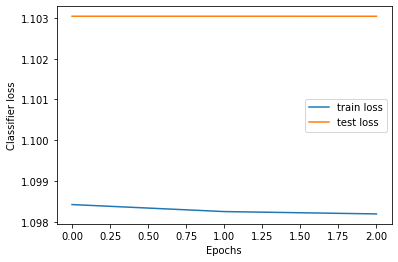

Training time: 0.31 min


In [141]:
clf, train_acc, test_acc, train_loss, test_loss = normal_training(epochs=3, batch_size = 32, learning_rate=0.01)